# Séries temporelles

### Imports

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import math
import plotly.express as px
from scipy import signal
import statsmodels.api as sm

### Questions

#### 1) Importez les données du fichier Openhealth_S-Grippal.csv. Consultez http://www.openhealth.fr/suivi-epidemiologique-temps-reel/ias-incidence-des-syndromes-grippaux pour plus d’information sur les données. Affichez les 5 premières lignes du jeu de données. On va travailler seulement avec la variable IAS_brut, sous la forme d’une série temporelle, dont on précisera la fréquence d’échantillonage et les dates de début et de fin. Pour cette variable, dans ce jeu de données, les cas de nullité correspondent à des données manquantes. Combien de données manquantes comporte-t-elle ? Pour les traitements des questions suivantes, éliminez les données manquantes par imputation, c’est-à-dire en déduisant une valeur plus “raisonnable” aux dates non-observées à partir des valeurs aux dates observées : par exemple par la moyenne de deux dates les plus proches.

In [90]:
df=pd.read_csv("OpenhealthS-Grippal.csv", delimiter=";", encoding="latin-1", decimal=",", na_values=0)

In [91]:
df.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
0,2009-07-01,1.7,2.2,2.3
1,2009-07-02,3.4,2.1,2.3
2,2009-07-03,2.1,2.1,2.3
3,2009-07-04,1.3,2.0,2.3
4,2009-07-05,14.2,2.0,2.3


In [92]:
df.describe

<bound method NDFrame.describe of          PERIODE  IAS_brut  IAS_lisse  Incidence_Sentinelles
0     2009-07-01       1.7        2.2                    2.3
1     2009-07-02       3.4        2.1                    2.3
2     2009-07-03       2.1        2.1                    2.3
3     2009-07-04       1.3        2.0                    2.3
4     2009-07-05      14.2        2.0                    2.3
...          ...       ...        ...                    ...
1747  2014-04-13      77.9        1.8                    NaN
1748  2014-04-14       2.7        1.7                    NaN
1749  2014-04-15       1.0        1.6                    NaN
1750  2014-04-16       1.6        1.6                    NaN
1751  2014-04-17       0.4        1.6                    NaN

[1752 rows x 4 columns]>

In [93]:
df1 = df['IAS_brut']
df1.head()

0     1.7
1     3.4
2     2.1
3     1.3
4    14.2
Name: IAS_brut, dtype: float64

In [94]:
date_debut = min (df['PERIODE'])
print('La date de début est : ',date_debut)
date_fin = max(df['PERIODE'])
print('La date de fin est : ',date_debut)

La date de début est :  2009-07-01
La date de fin est :  2009-07-01


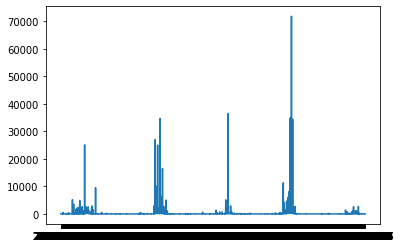

In [95]:
plt.plot(df['PERIODE'], df['IAS_brut'].values)
plt.show()

In [96]:
df['PERIODE-1']=pd.to_datetime(df['PERIODE'].shift())
df['PERIODE']=pd.to_datetime(df['PERIODE'])

In [97]:
df['Frequence_dechantillonage'] = pd.to_datetime(df['PERIODE']) - pd.to_datetime(df['PERIODE-1'])
df.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles,PERIODE-1,Frequence_dechantillonage
0,2009-07-01,1.7,2.2,2.3,NaT,NaT
1,2009-07-02,3.4,2.1,2.3,2009-07-01,1 days
2,2009-07-03,2.1,2.1,2.3,2009-07-02,1 days
3,2009-07-04,1.3,2.0,2.3,2009-07-03,1 days
4,2009-07-05,14.2,2.0,2.3,2009-07-04,1 days


La période est d'un jour, donc la fréquence N = 1/T = 1 / 1 jour = 1 jour⁻1 ou N = 1 / 86 400 secondes = 11,574 µHz 

In [98]:
df['IAS_brut'].isnull().sum()

8

In [99]:
df['IAS_brut'] = df['IAS_brut'].replace(df[df['IAS_brut'] == 0], np.NaN)

In [100]:
imp = SimpleImputer(missing_values=np.NaN, strategy='mean')

In [101]:
df['IAS_brut'] = imp.fit_transform(df['IAS_brut'].values.reshape(-1,1))

In [102]:
df['IAS_brut'].isnull().sum()

0

#### 2) Tracez la série temporelle considérée en fonction du temps. Commentez brièvement ce que vous observez.

In [103]:
fig = px.line(df, x='PERIODE', y='IAS_brut')
fig.show()

Nous observons des gaussiennes (des saisonnalités), mais il y a un pic autour du mois de février à peu près de chaque année.

#### 3) Tracez l’histogramme de la loi marginale. Quel impact la distribution observée par l’histogramme a sur la trajectoire représentée à la question précédente ?

In [104]:
fig = px.histogram(df, x="IAS_brut", nbins=30)
fig.show()

On remarque que la majorité (1716) des valeurs se trouve entre 2500 et 2400. Le reste étant réparti ensuite entre 2500 et 7400 et ensuite entre 7500 et 12,4K. 

#### 4) Reprenez les questions précédentes après tranformations des observations par le logarithme naturel. Commentez.

In [105]:
fig = px.line(df, x='PERIODE', y=np.log(df['IAS_brut']))
fig.show()

On remarque que le pic très apparant sans logarithme disparait. On remarque une dispersion des valeurs.

In [106]:
fig = px.histogram(df, x=np.log(df["IAS_brut"]), nbins=30)
fig.show()

La transformation logarithmique a eu pour effet de diminuer et stabiliser la variance.

#### 5) En utilisant signal.perodogram() (du package signal importé depuis scipy), tracez le périodogramme des données. Expliquez les pics les plus significatifs que vous observez. Attention au fait que dans la communauté signal les spectres sont normalisées pour des fréquences absolues dans [−1/2, 1/2] plutôt que [−π, −π].

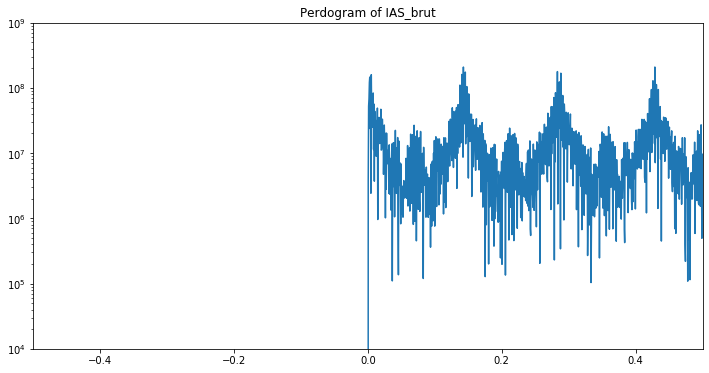

In [107]:
plt.figure(figsize=(12,6))
freq_abs, pow_spect = signal.periodogram(df['IAS_brut'])
plt.semilogy(freq_abs, pow_spect)
plt.xlim([-0.5, 0.5])
plt.ylim([1e+4, 1e+9])
plt.title('Perdogram of IAS_brut')
plt.show()

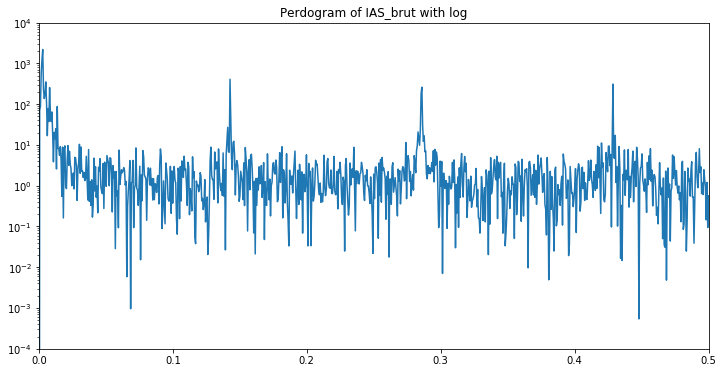

In [108]:
plt.figure(figsize=(12,6))
freq_abs, pow_spect = signal.periodogram(np.log(df['IAS_brut']))
plt.semilogy(freq_abs, pow_spect)
plt.xlim([0, 0.5])
plt.ylim([1e-4, 1e+4])
plt.title('Perdogram of IAS_brut with log')
plt.show()

Le signal se décompose en somme de cosinus et sinus et on cherche les fréquences qui représentent le mieux le signal. La somme des fonctions cosinus est un sinus.

#### 6) Pour supprimer une tendance périodique de période T dans un signal (xt)t∈Z il suffit d’appliquer le filtre ∆T défini par [∆T x]t = xt − xt−T. Utilisez cette méthode pour supprimer la tendance périodique de période 1 an. Quel pic du périodogramme cette méthode a fait disparaître ?

In [109]:
len(df['IAS_brut'])

1752

In [110]:
def difference(dataset, interval):
    diff = list()
    for i in range(0, interval):
        diff.append(np.NaN)
        
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

In [111]:
df['tendance_periodique'] = difference(df['IAS_brut'], 365)

In [112]:
df['tendance_periodique_log'] = difference(np.log(df['IAS_brut']), 365)

In [113]:
df

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles,PERIODE-1,Frequence_dechantillonage,tendance_periodique,tendance_periodique_log
0,2009-07-01,1.7,2.2,2.3,NaT,NaT,NaN,NaN
1,2009-07-02,3.4,2.1,2.3,2009-07-01,1 days,NaN,NaN
2,2009-07-03,2.1,2.1,2.3,2009-07-02,1 days,NaN,NaN
3,2009-07-04,1.3,2.0,2.3,2009-07-03,1 days,NaN,NaN
4,2009-07-05,14.2,2.0,2.3,2009-07-04,1 days,NaN,NaN
...,...,...,...,...,...,...,...,...
1747,2014-04-13,77.9,1.8,NaN,2014-04-12,1 days,74.9,3.256814
1748,2014-04-14,2.7,1.7,NaN,2014-04-13,1 days,0.3,0.117783
1749,2014-04-15,1.0,1.6,NaN,2014-04-14,1 days,-4.8,-1.757858
1750,2014-04-16,1.6,1.6,NaN,2014-04-15,1 days,-0.9,-0.446287


In [114]:
df1 = df.loc[365:,]
df1.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles,PERIODE-1,Frequence_dechantillonage,tendance_periodique,tendance_periodique_log
365,2010-07-01,1.0,0.6,1.3,2010-06-30,1 days,-0.7,-0.530628
366,2010-07-02,0.9,0.6,1.3,2010-07-01,1 days,-2.5,-1.329136
367,2010-07-03,0.5,0.6,1.3,2010-07-02,1 days,-1.6,-1.435085
368,2010-07-04,1.2,0.7,1.3,2010-07-03,1 days,-0.1,-0.080043
369,2010-07-05,0.6,0.7,0.6,2010-07-04,1 days,-13.6,-3.164068


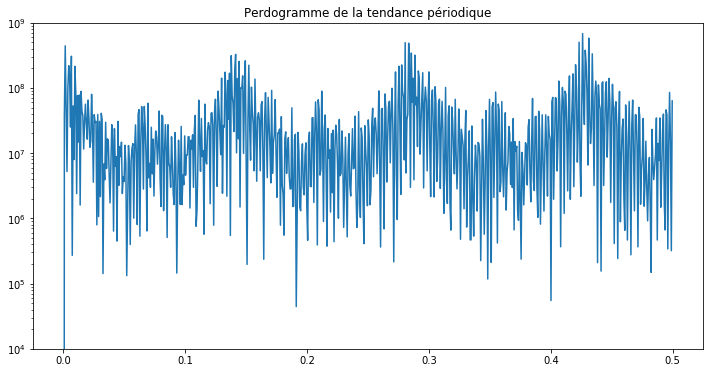

In [115]:
plt.figure(figsize=(12,6))
freq_abs1, pow_spect1 = signal.periodogram(df1['tendance_periodique'])
plt.semilogy(freq_abs1, pow_spect1)
plt.ylim([1e+4, 1e+9])
plt.title('Perdogramme de la tendance périodique')
plt.show()

A 0, on a une fréquence fondamentale. Le pic correspondant à la fréquence N = 1/365 = 0.0027397260273972603 a disparu. Si on commence à regarder à partir de la 365ème valeur (-0,7), on remarque une valeur inférieure, ce qui est expliqué par la disparition de ce pic.

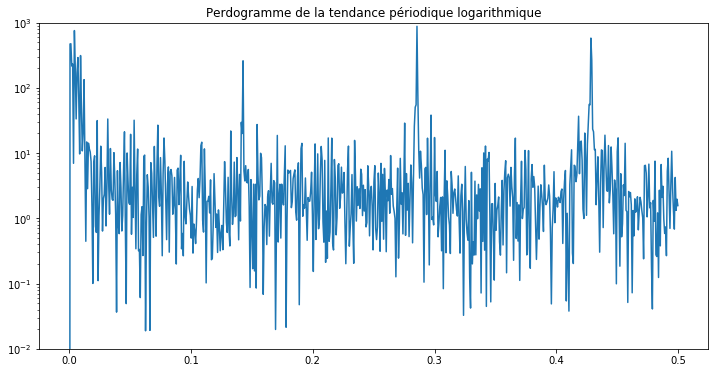

In [116]:
plt.figure(figsize=(12,6))
freq_abs1, pow_spect1 = signal.periodogram(df1['tendance_periodique_log'])
plt.semilogy(freq_abs1, pow_spect1)
plt.ylim([1e-2, 1e+3])
plt.title('Perdogramme de la tendance périodique logarithmique')
plt.show()

In [117]:
df.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles,PERIODE-1,Frequence_dechantillonage,tendance_periodique,tendance_periodique_log
0,2009-07-01,1.7,2.2,2.3,NaT,NaT,NaN,NaN
1,2009-07-02,3.4,2.1,2.3,2009-07-01,1 days,NaN,NaN
2,2009-07-03,2.1,2.1,2.3,2009-07-02,1 days,NaN,NaN
3,2009-07-04,1.3,2.0,2.3,2009-07-03,1 days,NaN,NaN
4,2009-07-05,14.2,2.0,2.3,2009-07-04,1 days,NaN,NaN


#### 7) On vous propose un exercise de prédiction uniquement à partir de la tendance périodique. On va prédire les valeurs de IAS_brut pour les dates du 1er avril 2013 au 17 avril 2014 en se basant sur les observations précédentes (du 1er juillet 2009 au 31 mars 2013) pour estimer la tendance périodique des données. Pour cela, pour un nombre d’harmoniques fixé (disons n_harm), construisez les variables explicatives pour la période d’apprentissage : pour chaque k = 1, 2, ... n_harm, ajoutez deux variables explicatives, xi,2k−1 = cos(ti·k·2π) et xi,2k = sin(ti·k·2πT), où ti est le moment de temps (on peut utiliser les nombres entiers au lieu de dates) et T = 365. Estimez la tendance périodique en régressant les données d’apprentissage sur ces variables explicatives. Avec ce modèle linéaire, prédisez les valeurs du variable IAS_brut pour la période du 1er avril 2013 au 17 avril 2014. Tracez les valeurs de la série temporelle et votre prédiction pour l’ensemble de données (vous pouvez utiliser les couleurs différentes pour pour les partie apprentissage et prédiction). Puis, donnez le risque quadratique de la prédiction et tracez les résidus pour la période prédite. Essayez les valeurs de n_harm pour voir comment varie le risque quadratique de la prédiction.

In [118]:
df['ti'] = df.index
df.reindex(df['ti'])
df.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles,PERIODE-1,Frequence_dechantillonage,tendance_periodique,tendance_periodique_log,ti
0,2009-07-01,1.7,2.2,2.3,NaT,NaT,NaN,NaN,0
1,2009-07-02,3.4,2.1,2.3,2009-07-01,1 days,NaN,NaN,1
2,2009-07-03,2.1,2.1,2.3,2009-07-02,1 days,NaN,NaN,2
3,2009-07-04,1.3,2.0,2.3,2009-07-03,1 days,NaN,NaN,3
4,2009-07-05,14.2,2.0,2.3,2009-07-04,1 days,NaN,NaN,4


In [119]:
n_harm = 4 

for k in range(1, n_harm) :
    df['x' + str(k)+'(cos)'] = np.cos(df.index * k * 2 * math.pi / 365)
    df['x' + str(k) + '(sin)'] = np.sin(df['ti'] * k * 2 * math.pi / 365)

In [120]:
df.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles,PERIODE-1,Frequence_dechantillonage,tendance_periodique,tendance_periodique_log,ti,x1(cos),x1(sin),x2(cos),x2(sin),x3(cos),x3(sin)
0,2009-07-01,1.7,2.2,2.3,NaT,NaT,NaN,NaN,0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,2009-07-02,3.4,2.1,2.3,2009-07-01,1 days,NaN,NaN,1,0.999852,0.017213,0.999407,0.034422,0.998667,0.051620
2,2009-07-03,2.1,2.1,2.3,2009-07-02,1 days,NaN,NaN,2,0.999407,0.034422,0.997630,0.068802,0.994671,0.103102
3,2009-07-04,1.3,2.0,2.3,2009-07-03,1 days,NaN,NaN,3,0.998667,0.051620,0.994671,0.103102,0.988023,0.154309
4,2009-07-05,14.2,2.0,2.3,2009-07-04,1 days,NaN,NaN,4,0.997630,0.068802,0.990532,0.137279,0.978740,0.205104


In [124]:
X_train = df[np.logical_and(df['PERIODE'] >= "2009-07-01" , df['PERIODE'] <= "2013-03-31")].drop(['IAS_lisse', 'Incidence_Sentinelles', 'PERIODE-1', 'Frequence_dechantillonage','tendance_periodique', 'tendance_periodique_log'], axis=1)
X_test = df[np.logical_and(df['PERIODE'] >= "2013-04-01" , df['PERIODE'] <= "2014-04-17")].drop(['IAS_lisse', 'Incidence_Sentinelles', 'PERIODE-1', 'Frequence_dechantillonage','tendance_periodique', 'tendance_periodique_log'], axis=1)

In [127]:
X_train.head()

,PERIODE,IAS_brut,ti,x1(cos),x1(sin),x2(cos),x2(sin),x3(cos),x3(sin)
0,2009-07-01,1.7,0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,2009-07-02,3.4,1,0.999852,0.017213,0.999407,0.034422,0.998667,0.051620
2,2009-07-03,2.1,2,0.999407,0.034422,0.997630,0.068802,0.994671,0.103102
3,2009-07-04,1.3,3,0.998667,0.051620,0.994671,0.103102,0.988023,0.154309
4,2009-07-05,14.2,4,0.997630,0.068802,0.990532,0.137279,0.978740,0.205104


In [128]:
y_train = X_train['IAS_brut']
X_train = X_train.drop(['IAS_brut', 'PERIODE'], axis=1)

In [129]:
X_train.head()

,ti,x1(cos),x1(sin),x2(cos),x2(sin),x3(cos),x3(sin)
0,0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,1,0.999852,0.017213,0.999407,0.034422,0.998667,0.051620
2,2,0.999407,0.034422,0.997630,0.068802,0.994671,0.103102
3,3,0.998667,0.051620,0.994671,0.103102,0.988023,0.154309
4,4,0.997630,0.068802,0.990532,0.137279,0.978740,0.205104


In [130]:
model = sm.OLS(y_train,X_train)
results = model.fit()
results.params

ti           0.458850
x1(cos)   -513.759911
x1(sin)   -183.679908
x2(cos)    195.615889
x2(sin)    361.933201
x3(cos)    101.167259
x3(sin)   -259.759153
dtype: float64

In [131]:
results.tvalues

ti         4.355019
x1(cos)   -4.352210
x1(sin)   -1.566166
x2(cos)    1.669661
x2(sin)    3.076875
x3(cos)    0.862792
x3(sin)   -2.217134
dtype: float64

In [137]:
results.predict()

array([-216.97676185, -220.80469367, -224.95958185, ...,  403.28295395,
        376.15131688,  349.86563041])

In [142]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X_train, y_train, 'b-', label="True")
ax.plot(X_test, results.predict(), 'r--.', label="Predicted")

ValueError: x and y must have same first dimension, but have shapes (382, 9) and (1370,)

ValueError: view limit minimum -69.499990276723 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [141]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
prstd, iv_l, iv_u = wls_prediction_std(results)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X_train, y_train, 'b-', label="True")
ax.plot(X_test, results.fittedvalues, 'r--.', label="Predicted")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
legend = ax.legend(loc="best")

ValueError: x and y must have same first dimension, but have shapes (382, 9) and (1370,)

ValueError: view limit minimum -69.499990276723 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units